# HW1 Problem 3: Instructions

To test your code on the Gradescope autograder, please upload a .zip file with 3 files:

*   `unicycle.py`
*   `pure_pursuit.py`
*   `better_controller.py`

Some of the files can be blank/incomplete if you haven't gotten to that part yet. But, make sure all 3 files exist in your .zip file. Also, make sure to include the necessary imports and auxiliary functions in each file that you upload.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm

# 3a) Dynamics / Environment

This cell defines the `Unicycle` class using the [Gym API](https://github.com/openai/gym). Your job is to finish implementing the `step` method, which should apply `action` = [$v$, $\omega$] to the system by updating `self.state` = [$p_x$, $p_y$, $\theta$]. You shouldn't need to change the rest of the code in this class.

Note: You should ensure that $\theta$ doesn't go beyond $[-\pi, \pi]$ (if it does, make sure to wrap around so that `self.state[2]` $\in [-\pi, \pi]$.

In [2]:
class Unicycle(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self):
    super(Unicycle, self).__init__()
    # The unicycle model has 2 control inputs: linear & angular velocity. We
    # will limit the controller from commanding values beyond these limits
    self.action_space = gym.spaces.Box(
        low=np.array([0, -2*np.pi], dtype=np.float32),
        high=np.array([1., 2*np.pi], dtype=np.float32),
        dtype=np.float32)
    # The unicycle model has 3 states: px, py, theta
    self.observation_space = gym.spaces.Box(
        low=np.array([-100., -100., np.pi], dtype=np.float32),
        high=np.array([100., 100., np.pi], dtype=np.float32),
        dtype=np.float32)

    # We will observe & control the system every self.dt seconds
    self.dt = 0.1

    # The system starts in a random state within these state limits
    self.init_state_range = np.array([
        [-2., 2.],
        [-2., 2.,],
        [-np.pi, np.pi]
    ])

    # The goal position will be within this box, but outside a circle around origin
    self.goal_pos_range = np.array([
        [-10., 10.],
        [-10., 10.,],
    ])
    self.goal_min_radius = 4.


  def step(self, action):
    # Execute one time step within the environment
    new_state = np.empty_like(self.state)
    action = np.clip(action, self.action_space.low, self.action_space.high)

    px, py, theta = self.state

    # Update the position and angle based on the unicycle kinematics equations
    rot = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])

    x_dot = np.matmul(rot, action)

    px_new = px + x_dot[0] * self.dt
    py_new = py + x_dot[1] * self.dt
    theta_new = theta + x_dot[2] * self.dt

    # Update the state
    new_state[0] = px_new
    new_state[1] = py_new
    new_state[2] = theta_new

    self.state = new_state
    self.state_history.append(new_state)

    obs = self.get_obs()
    self.obs_history.append(obs)

    # Check if we have reached the goal
    dist_to_goal = np.linalg.norm(self.goal - new_state[0:2])
    if dist_to_goal < 0.5:
      reward = 1
      done = True
    else:
      reward = 0
      done = False

    info = {}

    return obs, reward, done, info

  def reset(self):
    
    # Set goal that's within the goal limits but outside a circle around origin
    goal = self.get_goal()
    while goal[0]**2+goal[1]**2 < self.goal_min_radius**2:
      goal = self.get_goal()
    self.goal = goal
    
    # Reset the state of the environment to an initial state
    self.state = np.random.uniform(low=self.init_state_range[:, 0],
                                   high=self.init_state_range[:, 1])
    self.state_history = [self.state]
    obs = self.get_obs()
    self.obs_history = [obs]

    return obs
  
  def get_goal(self):
    return np.random.uniform(low=self.goal_pos_range[:, 0], high=self.goal_pos_range[:, 1])

  def get_obs(self):
    return self.state

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    return

  def plot(self):
    plt.figure()
    state_history = np.stack(self.state_history)

    # Draw the path taken by the vehicle
    plt.plot(state_history[:, 0], state_history[:, 1])

    # Draw a green star at the goal position
    plt.plot(self.goal[0], self.goal[1], marker='*', ms=20, c='tab:green')

    # Draw a red x at the starting location
    plt.plot(state_history[0, 0], state_history[0, 1],
             marker='x', ms=20, c='tab:red')
    
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.gca().set_aspect('equal')
    plt.show()

**Grading:** [2pts] To get points for this part, please paste the above cell (with your added implementation) into a file called `unicycle.py` and upload that to Gradescope. The autograder will run some tests to make sure your model is implemented correctly, which is recommended before moving on to the next parts.

# 3b) Open-Loop Control

Now that we have our kinematic model, let's try to command the system to reach a goal position. We will start with open-loop control, meaning we will measure the intial state (returned by `env.reset`) and then calculate a sequence of actions to apply.

After that sequence is computed, we will run the system forward for several steps, and at each step, we will simply grab the corresponding control value from that pre-computed sequence. You can use this example `open_loop_control_policy` implementation as a first try.

Your job is to implement a smarter `open_loop_control_policy` that gets the system to reach (close) to the goal.

Remember: you are only provided with the initial state, goal position, and the maximum number of steps allowed -- you can't access the system's state once it has started moving! That would be closed-loop control, which we'll implement next :)

In [3]:
def open_loop_control_policy(init_state, goal, num_steps=10):
    control_sequence = [np.array([1, 0.45]) for _ in range(num_steps)]
    print(len(control_sequence))

    return control_sequence

200


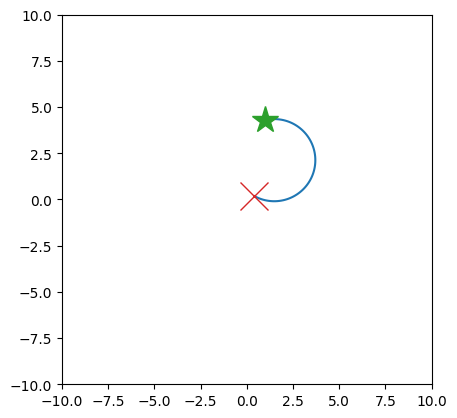

Success! Your open-loop controller drove the system to the goal.


In [4]:
np.random.seed(0)
max_num_steps = 200

env = Unicycle()
obs = env.reset() # initial observation of the system's state vector
control_sequence = open_loop_control_policy(obs, env.goal, num_steps=max_num_steps)

# Now that we've computed the control sequence, run the system forward until
# we reach max_num_steps or the system's state is close to the goal
for step in range(max_num_steps):
  action = control_sequence[step]
  obs, reward, done, info = env.step(action)
  if done:
    break

# Generate a simple plot of the path taken
env.plot()

if done:
  print('Success! Your open-loop controller drove the system to the goal.')
else:
  print('Your open-loop controller did not successfully drive the system to the goal.')

Now, let's see what happens if we try that same `control_sequence` on a version of the environment where the wheels are a little bit slippery, so our simple unicycle model does not describe the true system perfectly.



In [5]:
class NoisyUnicycle(Unicycle):
  """Same as Unicycle but add noise to the obs rather than returning perfect state."""
  def __init__(self):
    super().__init__()

  def get_obs(self):
    """Add sensor noise to the state measurements."""
    noise_limit = np.array([0.1, 0.1, 0.5])
    obs = self.state + np.random.uniform(low=-noise_limit, high=noise_limit)
    return obs
  
  def step(self, action):
    """Add process noise to the kinematics model."""
    obs, reward, done, info = super().step(action)
    new_state = np.empty_like(self.state)
    noise_limit = np.array([0.1, 0.1, 0.5])
    new_state = self.state + np.random.uniform(low=-noise_limit, high=noise_limit)

    self.state = new_state
    self.state_history[-1] = new_state

    obs = self.get_obs()
    self.obs_history[-1] = obs

    return obs, reward, done, info

200


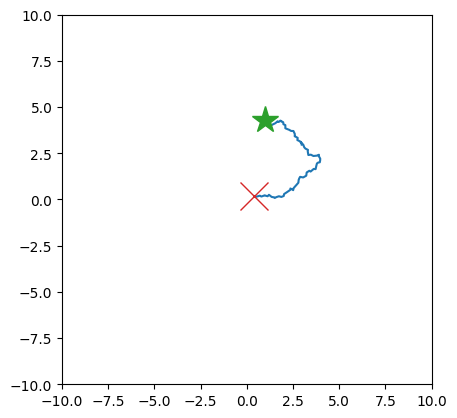

Success! Your open-loop controller drove the system to the goal.


In [6]:
np.random.seed(0)
max_num_steps = 200

env = NoisyUnicycle()
obs = env.reset()
control_sequence = open_loop_control_policy(obs, env.goal, num_steps=max_num_steps)

# Now that we've computed the control sequence, run the system forward until
# we reach max_num_steps or the system's state is close to the goal
for step in range(max_num_steps):
  action = control_sequence[step]
  obs, reward, done, info = env.step(action)
  if done:
    break

# Generate a simple plot of the path taken
env.plot()

if done:
  print('Success! Your open-loop controller drove the system to the goal.')
else:
  print('Your open-loop controller did not successfully drive the system to the goal.')

Your open-loop control sequence probably does not drive the system to the goal anymore. This is to be expected! It's like trying to park a car in a parking spot with your eyes closed. We will implement a much smarter strategy next.

**Grading:** [2pts] To get points for this part, please upload your jupyter notebook to Gradescope and we will take a look at the 2 plots above to make sure 1) your open-loop controller drives the noise-free system to the goal [1pt] and 2) you ran the open-loop controller on the noisy system too [1pt].

# 3c) Closed-Loop Control: Pure Pursuit Algorithm

One of the most powerful ideas in robotics is *feedback*. In this next part, we will implement a controller that measures the system's state at each step and uses that measurement to compute an action. This way, if the system ended up in a slightly different state than was expected from the simple model, the state measurement will contain information about this discrepancy. Feedback control is often a great way to compensate for imperfect knowledge of the system you are working with.

Your job is to implement the `PurePursuitController` class with a `get_action` method that takes in the current `obs` and the `env.goal` coordinate (expressed in the global frame), and outputs one `action` = $[v, \omega]$. This `get_action` method will be called at each step, so there is no need to calculate a whole sequence of actions. The controller that you implement should be capable of driving the system to the goal.

In [90]:
class PurePursuitController:
  def __init__(self, controller_name='pure_pursuit_controller', L=3.):
    """Store any hyperparameters here."""
    self.controller_name = controller_name
    self.L = L

  def get_action(self, obs, goal):
    """Compute the linear and angular velocities needed to follow a path towards the goal."""
    x, y, theta = obs
    goal_x, goal_y = goal

    # transform goal point to vehicle frame
    goal_x_v = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
    goal_y_v = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)

    # compute curvature
    curvature = 2 * goal_y_v / self.L**2

    # compute linear and angular velocities

    linear_speed = 1
    angular_speed = curvature * linear_speed

    return np.array([linear_speed, angular_speed])

This `validation` function may come in handy for debugging/testing your controller in some random scenarios

In [46]:
def validation(controller, system=Unicycle, plot=False, num_runs=100, max_num_steps_per_run=200):
  success_per_run = np.empty((num_runs,), dtype=bool)
  num_steps_per_run = np.empty((num_runs,))
  for i in range(num_runs):
    np.random.seed(i)
    env = system()
    obs = env.reset()
    for step in range(max_num_steps_per_run):
      action = controller.get_action(obs, env.goal)
      obs, reward, done, info = env.step(action)
      if done:
        break

    success_per_run[i] = done
    num_steps_per_run[i] = step
    if plot: env.plot()
  
  avg_success = np.mean(success_per_run)
  avg_steps = np.mean(num_steps_per_run)
  return avg_success, avg_steps

For example, you can run your controller on 3 random cases and plot the resulting paths:

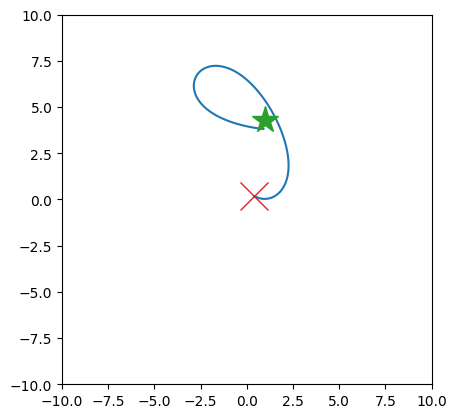

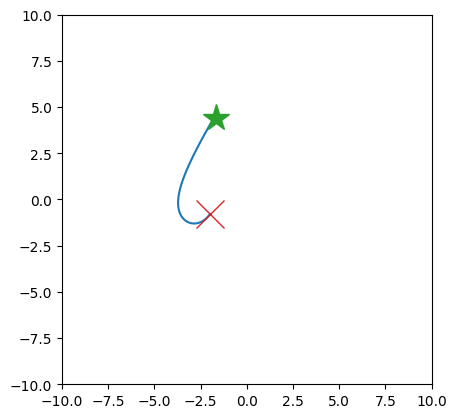

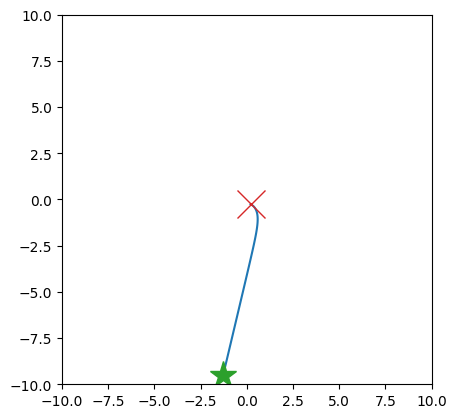

(1.0, 109.66666666666667)

In [91]:
pure_pursuit_controller = PurePursuitController(L=3.)
validation(controller=pure_pursuit_controller, num_runs=3, plot=True)

Once you're happy with your controller, you can run it against a larger validation test suite. This function will return the success rate (between 0 and 1) and average number of steps it takes your system to reach the goal.

In [92]:
pure_pursuit_controller = PurePursuitController(L=0.01)
avg_success, avg_steps = validation(controller=pure_pursuit_controller)
print("Success rate:", avg_success)
print("Avg. Number of Steps:", avg_steps)

Success rate: 1.0
Avg. Number of Steps: 85.54


Now we have a closed-loop controller that will drive the system to the goal.

Let's see if that controller can handle the noisy version of the Unicycle model:

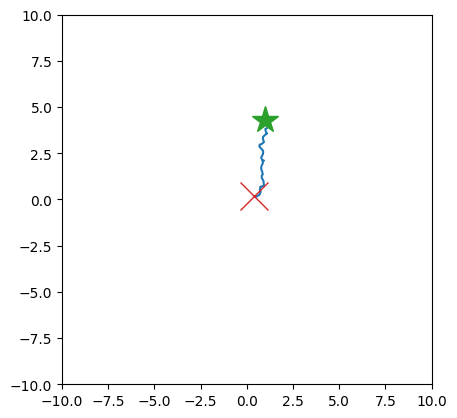

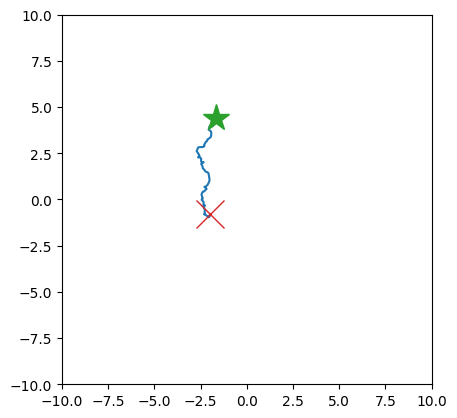

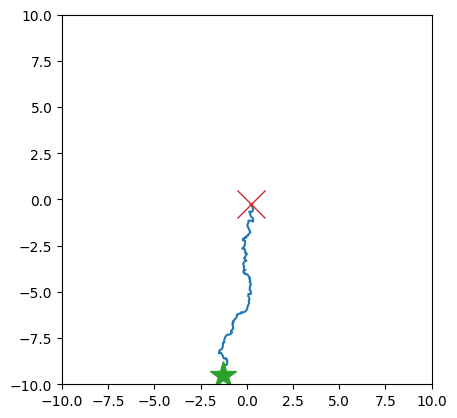

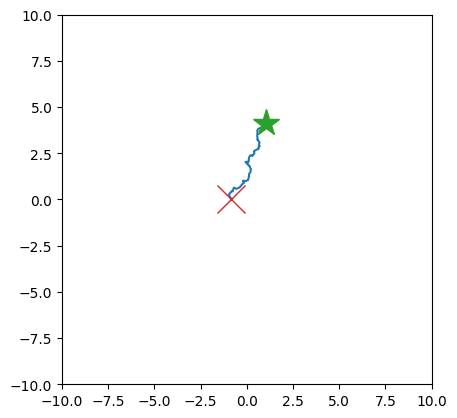

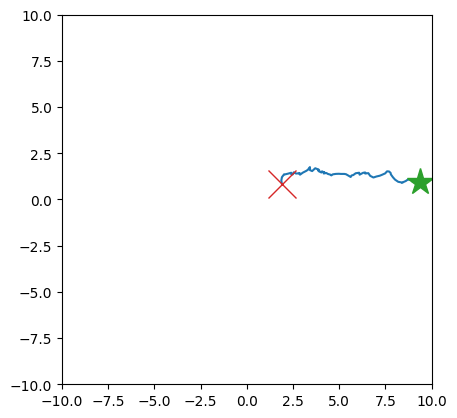

Success rate: 1.0
Avg. Number of Steps: 66.8


In [65]:
pure_pursuit_controller = PurePursuitController(L=0.1)
avg_success, avg_steps = validation(controller=pure_pursuit_controller, system=NoisyUnicycle, num_runs=5, plot=True)
print("Success rate:", avg_success)
print("Avg. Number of Steps:", avg_steps)

Hopefully the answer is yes! Even though the vehicle doesn't perfectly follow the curve that the pure pursuit algorithm had in mind, the feedback control strategy compensates for the imperfect knowledge of the dynamics and drives the system to the goal.

**Grading:** [3pts] To get points for this part, please paste your `PurePursuitController` class into a file called `pure_pursuit.py` and upload it to Gradescope. Please implement pure pursuit for this part, rather than another algorithm.

To encourage you to experiment with the effect of different hyperparameters in your algorithm (e.g., the lookahead distance), you will get [1 point] if you get a success rate of 100%, and [2 points] if you get a success rate of 100% with an average number of steps below 82. To get [3 points], please also include some plots and text (one paragraph maximum) in the writeup you upload to gradescope (with Problem 1 etc) describing your observations about the impact of hyperparameters on your algorithm.

Note: The autograder will simply instantiate your controller by running `PurePursuitController()`, so make sure that any hyperparameters default to the values you would like (e.g., use keyword arguments with default values for your lookahead distance).

# 3d) Extra Credit: Make your algorithm even better

Prof. Everett's simple pure pursuit implementation used an average number of steps of 79.44 on the validation set. You can earn 1 extra credit point if you upload a second implementation to Gradescope achieves below 75 steps on average (while also achieving 100% success). You can try different strategies than just pure pursuit. Please give this one a filename of `better_controller.py` with class name `BetterController`, but otherwise the class/function signatures should be the same as before.

Note: there will be a test suite that is similar but not identical to the validation method above to ensure your algorithm doesn't overfit to specific cases.